In [1]:
%matplotlib inline

In [2]:
from __future__ import division,print_function

import os, json
import shutil
from glob import glob
import random
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image 

In [3]:
from importlib import reload
import utils; reload(utils)
from utils import plots

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_ccyjt76l.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: Tesla P4 (0000:00:08.0)
Using Theano backend.


In [4]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam

## Create validation set and sample

In [5]:
NB_ROOT = os.getcwd()

In [6]:
DATA_HOME_DIR = os.path.join(NB_ROOT, "data/state-farm-distracted-driver-detection")
results_path = os.path.join(DATA_HOME_DIR, 'results')

In [7]:
%mkdir -p $DATA_HOME_DIR
%cd $DATA_HOME_DIR
%mkdir -p valid
%mkdir -p results
%mkdir -p sample/train
%mkdir -p sample/test/unknown
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/mnt/ml/working/fastai-courses/deeplearning1/nbs/data/state-farm-distracted-driver-detection


In [8]:
# !kg download -c state-farm-distracted-driver-detection
#!mv test/*.jpg test/unknown

## Inspect the Driver-imgs sheet

In [9]:
driver_imgs = pd.read_csv('driver_imgs_list.csv')

In [10]:
driver_imgs.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [11]:
driver_imgs.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_78052.jpg
freq,1237,2489,1


In [12]:
driver_imgs.groupby('subject').agg('count')

,classname,img
subject,,
p002,725,725
p012,823,823
p014,876,876
p015,875,875
p016,1078,1078
p021,1237,1237
p022,1233,1233
p024,1226,1226
p026,1196,1196


In [13]:
def show_driver_img(subject):
    df = driver_imgs.loc[driver_imgs['subject']==subject].sample(frac=0.01)
    imgs = []
    for idx, row in df.iterrows():
        path = 'train/{}/{}'.format(row['classname'], row['img'])
        imgs.append(mpimg.imread(path))
    plots(imgs, figsize=(24,12))

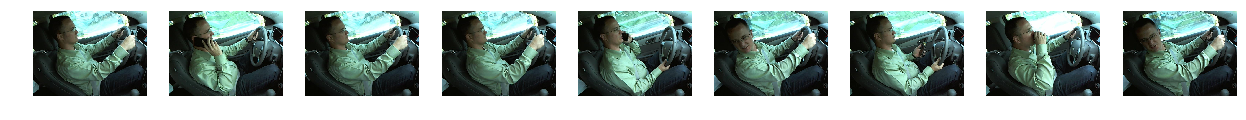

In [14]:
show_driver_img('p051')

In [15]:
# Create valid set img dirs(with lables)
for i in range(10):
    try:
        os.makedirs('valid/c{}/'.format(i))
    except FileExistsError:
        pass

In [16]:
def move_driver_to_validset(subject):
    df = driver_imgs.loc[driver_imgs['subject']==subject]
    for idx, row in df.iterrows():
        train_path = 'train/{}/{}'.format(row['classname'], row['img'])
        valid_dir = 'valid/{}'.format(row['classname'])
        shutil.move(train_path, valid_dir)
        

In [17]:
# move_driver_to_validset('p014')
# move_driver_to_validset('p064')
# move_driver_to_validset('p015')

# Build Model

In [18]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, BatchNormalization

In [19]:
class Vgg16(object):
    def __init__(self, input_shape=(224, 224, 3),):
        self.input_shape = input_shape
        self.build()
    
    def build(self):
        base_model = applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )
        for layer in base_model.layers:
            layer.trainable = False
        
        top_model = Sequential()
        top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
        top_model.add(Dense(256, activation='relu'))
        top_model.add(BatchNormalization())
        top_model.add(Dropout(0.5))
        top_model.add(Dense(256, activation='relu'))
        top_model.add(BatchNormalization())
        top_model.add(Dropout(0.5))
        top_model.add(Dense(10, activation='softmax'))
        
        model = Model(
            inputs=base_model.input,
            outputs=top_model(base_model.output)
        )
        model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-6),
            metrics=['accuracy']
        )
        
        self.base_model = base_model
        self.top_model = top_model
        self.model = model

    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs, train_batches, valid_batches):
        for epoch in range(epochs):
            print("Running epoch: %d" % epoch)
            self.model.fit_generator(
                train_batches,
                epochs=1,
                steps_per_epoch=train_batches.samples//BATCH_SIZE,
                validation_data=valid_batches,
                validation_steps=valid_batches.samples//BATCH_SIZE,
            )
            latest_weights_filename = 'ft%d.h5' % epoch
            #self.model.save_weights(os.path.join(results_path, latest_weights_filename))
            print("Completed %s fit operations" % epoch)


In [20]:
# !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 --no-check-certificate -P ~/.keras/models


In [21]:
model = Vgg16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Train

In [22]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=16, class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        # 224x224 is the image size used by ImageNet
        return gen.flow_from_directory(
            path, target_size=(224,224),
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size
        )

In [23]:
_path = DATA_HOME_DIR
# _path = DATA_HOME_DIR + '/sample' # Only for sample tests!
test_path = os.path.join(DATA_HOME_DIR, 'test')
results_path = os.path.join(DATA_HOME_DIR, 'results')
train_path = os.path.join(_path, 'train')
valid_path = os.path.join(_path, 'valid')
test_path = os.path.join(_path, 'test')

In [24]:
! cd $NB_ROOT
BATCH_SIZE=64

train_batches = get_batches(train_path, batch_size=BATCH_SIZE)
valid_batches = get_batches(valid_path, batch_size=BATCH_SIZE*2)

Found 19853 images belonging to 10 classes.
Found 2571 images belonging to 10 classes.


## Fine tune 2 epochs with low learning rate(1)

In [ ]:
model.fit(2, train_batches, valid_batches)

In [29]:
model.model.optimizer.lr = 1e-5

In [30]:
model.fit(1, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 332s 1s/step - loss: 2.9198 - acc: 0.1810 - val_loss: 2.5039 - val_acc: 0.1459
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 2.6209 - acc: 0.2320 - val_loss: 2.4144 - val_acc: 0.1727
Completed 1 fit operations


In [26]:
model.model.optimizer.lr = 1e-4
model.fit(1, train_batches, valid_batches)

In [32]:
model.model.optimizer.lr = 1e-3
model.fit(1, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 329s 1s/step - loss: 2.1930 - acc: 0.3210 - val_loss: 2.2421 - val_acc: 0.2217
Completed 0 fit operations


In [33]:
model.fit(3, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 331s 1s/step - loss: 2.0110 - acc: 0.3633 - val_loss: 2.1724 - val_acc: 0.2542
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 330s 1s/step - loss: 1.8540 - acc: 0.3993 - val_loss: 2.1074 - val_acc: 0.2786
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 332s 1s/step - loss: 1.7172 - acc: 0.4448 - val_loss: 2.0502 - val_acc: 0.3070
Completed 2 fit operations


In [34]:
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 330s 1s/step - loss: 1.5638 - acc: 0.4859 - val_loss: 2.0022 - val_acc: 0.3288
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 1.4344 - acc: 0.5226 - val_loss: 1.9571 - val_acc: 0.3488
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 1.3253 - acc: 0.5651 - val_loss: 1.9118 - val_acc: 0.3620
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 332s 1s/step - loss: 1.2322 - acc: 0.5922 - val_loss: 1.8736 - val_acc: 0.3748
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 330s 1s/step - loss: 1.1418 - acc: 0.6179 - val_loss: 1.8325 - val_acc: 0.3906
Completed 4 fit operations


In [35]:
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 1.0631 - acc: 0.6500 - val_loss: 1.8042 - val_acc: 0.4014
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 331s 1s/step - loss: 1.0061 - acc: 0.6700 - val_loss: 1.7724 - val_acc: 0.4124
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.9412 - acc: 0.6887 - val_loss: 1.7496 - val_acc: 0.4211
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 329s 1s/step - loss: 0.8722 - acc: 0.7171 - val_loss: 1.7278 - val_acc: 0.4329
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 330s 1s/step - loss: 0.8210 - acc: 0.7334 - val_loss: 1.7070 - val_acc: 0.4405
Completed 4 fit operations


In [36]:
model.fit(3, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.7647 - acc: 0.7517 - val_loss: 1.6849 - val_acc: 0.4541
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.7218 - acc: 0.7681 - val_loss: 1.6622 - val_acc: 0.4551
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.6754 - acc: 0.7836 - val_loss: 1.6463 - val_acc: 0.4627
Completed 2 fit operations


In [37]:
model.fit(3, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.6472 - acc: 0.7924 - val_loss: 1.6298 - val_acc: 0.4687
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 332s 1s/step - loss: 0.6021 - acc: 0.8111 - val_loss: 1.6114 - val_acc: 0.4749
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 330s 1s/step - loss: 0.5741 - acc: 0.8206 - val_loss: 1.6008 - val_acc: 0.4797
Completed 2 fit operations


In [38]:
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 329s 1s/step - loss: 0.5467 - acc: 0.8301 - val_loss: 1.5783 - val_acc: 0.4839
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 330s 1s/step - loss: 0.5132 - acc: 0.8402 - val_loss: 1.5578 - val_acc: 0.4895
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.4813 - acc: 0.8546 - val_loss: 1.5506 - val_acc: 0.4915
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 329s 1s/step - loss: 0.4692 - acc: 0.8582 - val_loss: 1.5319 - val_acc: 0.4991
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.4425 - acc: 0.8716 - val_loss: 1.5278 - val_acc: 0.5027
Completed 4 fit operations


In [34]:
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 378s 1s/step - loss: 0.3488 - acc: 0.8994 - val_loss: 1.4879 - val_acc: 0.5229
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.3226 - acc: 0.9101 - val_loss: 1.4819 - val_acc: 0.5251
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 330s 1s/step - loss: 0.3120 - acc: 0.9147 - val_loss: 1.4700 - val_acc: 0.5251
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.2971 - acc: 0.9167 - val_loss: 1.4781 - val_acc: 0.5269
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.2845 - acc: 0.9205 - val_loss: 1.4659 - val_acc: 0.5273
Completed 4 fit operations


In [35]:
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.2782 - acc: 0.9244 - val_loss: 1.4692 - val_acc: 0.5305
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.2631 - acc: 0.9281 - val_loss: 1.4670 - val_acc: 0.5319
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.2493 - acc: 0.9342 - val_loss: 1.4569 - val_acc: 0.5353
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.2510 - acc: 0.9322 - val_loss: 1.4467 - val_acc: 0.5395
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 325s 1s/step - loss: 0.2360 - acc: 0.9368 - val_loss: 1.4493 - val_acc: 0.5397
Completed 4 fit operations


In [36]:
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.2258 - acc: 0.9422 - val_loss: 1.4446 - val_acc: 0.5381
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.2195 - acc: 0.9429 - val_loss: 1.4360 - val_acc: 0.5421
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.2093 - acc: 0.9466 - val_loss: 1.4323 - val_acc: 0.5445
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.2068 - acc: 0.9465 - val_loss: 1.4272 - val_acc: 0.5443
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.1969 - acc: 0.9490 - val_loss: 1.4313 - val_acc: 0.5453
Completed 4 fit operations


In [37]:
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.1957 - acc: 0.9507 - val_loss: 1.4241 - val_acc: 0.5475
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.1829 - acc: 0.9535 - val_loss: 1.4172 - val_acc: 0.5473
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.1791 - acc: 0.9552 - val_loss: 1.4226 - val_acc: 0.5471
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.1737 - acc: 0.9569 - val_loss: 1.4054 - val_acc: 0.5529
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.1643 - acc: 0.9612 - val_loss: 1.4019 - val_acc: 0.5557
Completed 4 fit operations


In [39]:
model.model.save_weights('checkpoint.h5')
model.fit(5, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.1418 - acc: 0.9662 - val_loss: 1.3932 - val_acc: 0.5609
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 325s 1s/step - loss: 0.1354 - acc: 0.9687 - val_loss: 1.3966 - val_acc: 0.5605
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.1288 - acc: 0.9689 - val_loss: 1.3898 - val_acc: 0.5611
Completed 2 fit operations
Running epoch: 3
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.1334 - acc: 0.9681 - val_loss: 1.3826 - val_acc: 0.5665
Completed 3 fit operations
Running epoch: 4
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.1250 - acc: 0.9713 - val_loss: 1.3888 - val_acc: 0.5661
Completed 4 fit operations


In [41]:
model.model.save_weights('checkpoint.h5')
model.model.optimizer.lr = 1e-2
model.fit(3, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 328s 1s/step - loss: 0.1121 - acc: 0.9741 - val_loss: 1.3782 - val_acc: 0.5635
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.1105 - acc: 0.9747 - val_loss: 1.3724 - val_acc: 0.5687
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.1075 - acc: 0.9763 - val_loss: 1.3677 - val_acc: 0.5661
Completed 2 fit operations


In [42]:
model.model.optimizer.lr = 1e-3
for i in range(3):
    model.model.save_weights('checkpoint{}.h5'.format(i))
    model.fit(3, train_batches, valid_batches)

Running epoch: 0
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.1037 - acc: 0.9769 - val_loss: 1.3757 - val_acc: 0.5657
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.0983 - acc: 0.9776 - val_loss: 1.3666 - val_acc: 0.5671
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 326s 1s/step - loss: 0.0965 - acc: 0.9791 - val_loss: 1.3646 - val_acc: 0.5655
Completed 2 fit operations
Running epoch: 0
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.0973 - acc: 0.9774 - val_loss: 1.3700 - val_acc: 0.5695
Completed 0 fit operations
Running epoch: 1
Epoch 1/1
310/310 [==============================] - 325s 1s/step - loss: 0.0941 - acc: 0.9793 - val_loss: 1.3650 - val_acc: 0.5691
Completed 1 fit operations
Running epoch: 2
Epoch 1/1
310/310 [==============================] - 327s 1s/step - loss: 0.0921 - acc: 0.9797 - val_lo

## Predict

In [43]:
test_batches = get_batches(
    test_path, batch_size=BATCH_SIZE * 2, shuffle=False, class_mode=None)

Found 79726 images belonging to 1 classes.


In [44]:
def predict(model, test_batches):
    return model.predict_generator(test_batches, verbose=1)


In [45]:
preds = predict(model.model, test_batches)

623/623 [==============================] - 1216s 2s/step


In [46]:
sbm = pd.DataFrame(preds.copy(), columns="c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(','))
sbm['img'] = [f.replace('unknown/', '') for f in test_batches.filenames]
for col in "c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(','):
    sbm[col] = np.clip(sbm[col], 0.1, 0.9)

sbm = sbm.set_index(['img'])
sbm = sbm.sort_index()

In [47]:
sbm.to_csv('submission.csv')

In [48]:
!kg submit -c state-farm-distracted-driver-detection submission.csv

1.24674
